# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:
    -Second experiment:
        - (0, 0, 0.2)
        - (10, 10, 0.2)
- The simulator runs during 10 minutes in fast mode which is translated into 12 hours of collected data.

In [10]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

In [11]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,1.050733,1.094226,308.240738,0.059450,0.344226,128.240516,1.061660,1.289745,0.990510,...,1.000384,1.083896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.052836,1.093243,311.136141,0.002103,-0.000982,2.895403,1.129972,1.214009,1.135844,...,0.993033,1.009313,0.068312,-0.075736,0.145334,0.327937,0.133375,0.140812,-0.007352,-0.074582
2,2,1.054507,1.091473,315.074322,0.001672,-0.001770,3.938181,1.185616,1.131318,1.019394,...,0.956272,0.944564,0.055645,-0.082692,-0.116450,0.110155,0.029906,-0.014191,-0.036761,-0.064750
3,3,1.056316,1.089796,319.070072,0.001809,-0.001677,3.995750,1.098113,1.103999,1.094631,...,0.881076,1.000029,-0.087503,-0.027318,0.075237,0.054568,-0.004316,-0.045687,-0.075196,0.055465
4,4,1.058129,1.088026,323.456321,0.001812,-0.001770,4.386249,1.327904,1.104746,1.123384,...,0.842176,0.892464,0.229791,0.000746,0.028753,-0.037511,0.034774,-0.001614,-0.038900,-0.107565


## Data pre-processing

The data collected 1384848 samples.

In [12]:
df.shape

(1125965, 23)

The data set contains some null values so they should be deleted from the samples.

In [13]:
df = df.dropna()

## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [21]:
# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]
targets = sampled_df[['x', 'y']]
targets_angle = sampled_df[['theta']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:(train_size + test_size)]
test_targets = targets[train_size:(train_size + test_size)]

## Neural Network


As input the neural network receives the sensor measurements as input and the target are the x, y, $\theta$ coordinates.

In [29]:

def get_model(output):
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(8,)))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(output))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [16]:
def k_fold(num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=64, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse

In [ ]:
histories, nmse = k_fold(70, 3)

NMSE: 
0.98276360853308


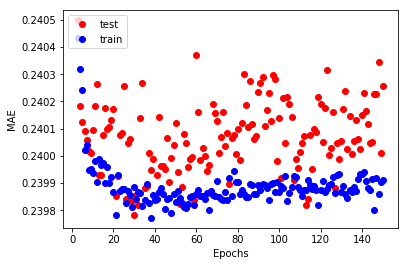

In [29]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 150
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

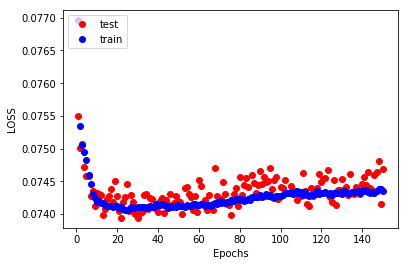

In [30]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [31]:
model = get_model(2)

history = model.fit(inputs, targets, epochs=10, batch_size=32, verbose=1)
history.history['mae']
model.save("nn_sensor_reverse_dist.h5")

Epoch 1/10
1125964/1125964 [==============================] - 74s 66us/step - loss: 0.2017 - mae: 0.3829
Epoch 2/10
1125964/1125964 [==============================] - 70s 62us/step - loss: 0.1987 - mae: 0.3813
Epoch 3/10
1125964/1125964 [==============================] - 94s 84us/step - loss: 0.1986 - mae: 0.3812 0s - loss: 0.1986 
Epoch 4/10
1125964/1125964 [==============================] - 93s 82us/step - loss: 0.1985 - mae: 0.3812
Epoch 5/10
1125964/1125964 [==============================] - 85s 76us/step - loss: 0.1985 - mae: 0.3812
Epoch 6/10
1125964/1125964 [==============================] - 93s 82us/step - loss: 0.1985 - mae: 0.3812
Epoch 7/10
1125964/1125964 [==============================] - 94s 84us/step - loss: 0.1985 - mae: 0.3812
Epoch 8/10
1125964/1125964 [==============================] - 86s 76us/step - loss: 0.1985 - mae: 0.3812
Epoch 9/10
1125964/1125964 [==============================] - 93s 83us/step - loss: 0.1985 - mae: 0.3812
Epoch 10/10
1125964/1125964 [=======

In [30]:
model = get_model(1)

history = model.fit(inputs, targets_angle, epochs=70, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_reverse_angle.h5")

Epoch 1/70
1125964/1125964 [==============================] - 41s 36us/step - loss: 12019.6614 - mae: 94.5960
Epoch 2/70
1125964/1125964 [==============================] - 51s 46us/step - loss: 10439.6409 - mae: 91.1809
Epoch 3/70
1125964/1125964 [==============================] - 48s 42us/step - loss: 10267.2820 - mae: 91.0652
Epoch 4/70
1125964/1125964 [==============================] - 45s 40us/step - loss: 10197.9572 - mae: 91.0328
Epoch 5/70
1125964/1125964 [==============================] - 46s 41us/step - loss: 10166.3950 - mae: 91.0221
Epoch 6/70
1125964/1125964 [==============================] - 36s 32us/step - loss: 10150.2998 - mae: 91.0223
Epoch 7/70
1125964/1125964 [==============================] - 36s 32us/step - loss: 10138.7229 - mae: 91.0126
Epoch 8/70
1125964/1125964 [==============================] - 33s 29us/step - loss: 10128.4303 - mae: 90.9991
Epoch 9/70
1125964/1125964 [==============================] - 40s 36us/step - loss: 10116.8459 - mae: 90.9737
Epoch 10/7

KeyboardInterrupt: 